In [116]:
import numpy as np
from pandas.core.interchange.dataframe_protocol import DataFrame
from scipy.stats import ttest_ind
from os import path
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.options.display.max_columns = None
pd.options.display.max_rows = 50
pd.options.mode.copy_on_write = True

In [117]:
df = pd.read_csv("db.csv")

df

,formula,type,activity,Syngony,shape,"length, nm","width, nm","depth, nm",Sufrace,surface,pol,surf,"Mw(coat), g/mol","Km, mM","Vmax, mM/s",ReactionType,Subtype,"C min, mM","C max, mM","C(const), mM",Ccat(mg/mL),ph,"temp, °C"
0,CoFe2O4,bimeo,peroxidase,7.0,NaN,4.1,4.1,4.1,additional,naked,oleic acid,0,282.47,0.0065,1.376300000,TMB + H2O2,TMB,1.50,1.5000,100.000,0.0000262,4.0,37.0
1,CoFe2O4,bimeo,peroxidase,7.0,nanopolyhedrons,13.8,13.8,13.8,additional,naked,oleic acid,0,282.47,0.0554,0.264300000,TMB + H2O2,TMB,1.50,1.5000,100.000,0.0000262,4.0,37.0
2,CoFe2O4,bimeo,peroxidase,7.0,NaN,4.1,4.1,4.1,additional,naked,oleic acid,0,282.47,0.0355,8.363000000,H2O2 + TMB,H2O2,0.50,25.0000,100.000,0.0000262,4.0,37.0
3,CoFe2O4,bimeo,peroxidase,7.0,nanopolyhedrons,13.8,13.8,13.8,additional,naked,oleic acid,0,282.47,0.2277,0.438200000,H2O2 + TMB,H2O2,0.50,25.0000,100.000,0.0000262,4.0,37.0
4,CoFe2O4,bimeo,peroxidase,7.0,near corner-grown cubic,24.5,24.5,24.5,additional,naked,oleic acid,0,282.47,0.0173,1.027200000,TMB + H2O2,TMB,0.20,100.0000,15.000,0.0000262,4.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,ZnFe2O4,bimeo,peroxidase,7.0,spherical,10.0,10.0,10.0,naked,naked,0,0,0.00,0.8139,0.000542000,TMB + H2O2,TMB,0.16,1.0000,8.820,0.0100000,4.0,37.0
1198,CeO2,meo,peroxidase,7.0,nanosheet,200.0,200.0,10.0,additional,naked,0,terephthalic acid,166.13,0.1630,0.001331000,TMB + H2O2,TMB,0.50,3.8000,NaN,2.0000000,NaN,NaN
1199,CeO2,meo,peroxidase,7.0,nanosheet,200.0,200.0,10.0,additional,naked,0,terephthalic acid,166.13,198.3400,0.001515000,H2O2 + TMB,H2O2,50.00,600.0000,NaN,2.0000000,NaN,NaN
1200,Ce,me,peroxidase,7.0,spherical,3.5,3.5,3.5,cover,citric acid,0,0,192.12,308.0000,no,TMB + H2O2,TMB,0.10,0.8000,NaN,0.2000000,7.4,NaN


In [118]:
def delete_empty_rows(data, column_names) -> DataFrame:
  for name in column_names:
    if name == 'Vmax, mM/s' or 'Km, mM':
      data = data[data[name] != "no"]
      continue
    data = data[~data[name].isnull()]
  return data

In [119]:
def delete_columns(data, column_names) -> DataFrame:
  new_data = data.drop(columns=column_names, axis=1)
  return new_data

In [120]:
def set_default_values(data, column_names) -> DataFrame:
  for name in column_names:
    value = data[name].iloc[0]
    data[name] = data[name].fillna(value)
  return data

In [121]:
def set_cconst_average_values(data, column_name = 'C(const), mM') -> DataFrame:
  new_data = data[~data[column_name].isnull()]
  new_data = new_data[data[column_name] != "?"]
  new_data = new_data[data[column_name] != "no"]
  new_data[column_name] = new_data[column_name].astype(str)
  new_data[column_name] = new_data[column_name].str.replace(',', '')
  new_data[column_name] = new_data[column_name].astype(float)
  mean = new_data[column_name].mean()
  data = data[data[column_name] != "?"]
  data = data[data[column_name] != "no"]
  data[column_name] = data[column_name].fillna(mean)
  return data

In [122]:
def set_temp_average_values(data, column_name = 'temp, °C'):
  new_data = data[~data[column_name].isnull()]
  new_data[column_name] = new_data[column_name].astype(float)
  mean = new_data[column_name].mean()
  data[column_name] = data[column_name].fillna(mean)
  data[column_name] = data[column_name].round(1)
  return data

In [123]:
def set_ph_average_values(data, column_name = 'ph'):
  new_data = data[~data[column_name].isnull()]
  new_data[column_name] = new_data[column_name].astype(float)
  mean = new_data[column_name].mean()
  data[column_name] = data[column_name].fillna(mean)
  data[column_name] = data[column_name].round(1)
  return data

In [124]:
def change_data_types(data, column_names):
  new_data = data
  for name in column_names:
    new_data[name] = new_data[name].astype(str)
    new_data[name] = new_data[name].str.replace(',', '')
    new_data[name] = new_data[name].astype(float)

  return new_data

In [125]:
def swap_reaction_type_in_column(data, types):
  for tp in types:
    data['ReactionType'] = data['ReactionType'].str.replace(tp[0], tp[1])
  return data

In [126]:
#Предобработка данных

delete_row_names = ['shape', 'Vmax, mM/s', 'Km, mM']
delete_column_names = ['length, nm', 'width, nm', 'depth, nm']
default_column_names = ['pol', 'Syngony', 'Ccat(mg/mL)', 'Mw(coat), g/mol']
change_data_columns = ['C max, mM', 'C(const), mM']
reaction_types = [["TMB + H2O2", "H2O2 + TMB"], ["H2O2 + OPD", "OPD + H2O2"]]

df = delete_empty_rows(df, delete_row_names)
df = delete_columns(df, delete_column_names)
df = set_default_values(df, default_column_names)
df = set_cconst_average_values(df)
df = set_temp_average_values(df)
df = set_ph_average_values(df)
df = change_data_types(df, change_data_columns)
df = swap_reaction_type_in_column(df, reaction_types)

df['formula'] = df['formula'].str.replace(" ", "")

df

C:\Users\Daniil Koreshkov\AppData\Local\Temp\ipykernel_17480\1402345194.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_data = new_data[data[column_name] != "?"]
C:\Users\Daniil Koreshkov\AppData\Local\Temp\ipykernel_17480\1402345194.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_data = new_data[data[column_name] != "no"]


,formula,type,activity,Syngony,shape,Sufrace,surface,pol,surf,"Mw(coat), g/mol","Km, mM","Vmax, mM/s",ReactionType,Subtype,"C min, mM","C max, mM","C(const), mM",Ccat(mg/mL),ph,"temp, °C"
0,CoFe2O4,bimeo,peroxidase,7.0,NaN,additional,naked,oleic acid,0,282.47,0.0065,1.376300000,H2O2 + TMB,TMB,1.50,1.5,100.000000,0.0000262,4.0,37.0
1,CoFe2O4,bimeo,peroxidase,7.0,nanopolyhedrons,additional,naked,oleic acid,0,282.47,0.0554,0.264300000,H2O2 + TMB,TMB,1.50,1.5,100.000000,0.0000262,4.0,37.0
2,CoFe2O4,bimeo,peroxidase,7.0,NaN,additional,naked,oleic acid,0,282.47,0.0355,8.363000000,H2O2 + TMB,H2O2,0.50,25.0,100.000000,0.0000262,4.0,37.0
3,CoFe2O4,bimeo,peroxidase,7.0,nanopolyhedrons,additional,naked,oleic acid,0,282.47,0.2277,0.438200000,H2O2 + TMB,H2O2,0.50,25.0,100.000000,0.0000262,4.0,37.0
4,CoFe2O4,bimeo,peroxidase,7.0,near corner-grown cubic,additional,naked,oleic acid,0,282.47,0.0173,1.027200000,H2O2 + TMB,TMB,0.20,100.0,15.000000,0.0000262,4.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,ZnFe2O4,bimeo,peroxidase,7.0,spherical,naked,naked,0,0,0.00,0.6049,0.000463000,H2O2 + TMB,TMB,0.16,1.0,8.820000,0.0100000,4.0,30.0
1196,ZnFe2O4,bimeo,peroxidase,7.0,spherical,naked,naked,0,0,0.00,1.0328,0.000707000,H2O2 + TMB,TMB,0.16,1.0,8.820000,0.0100000,3.6,37.0
1197,ZnFe2O4,bimeo,peroxidase,7.0,spherical,naked,naked,0,0,0.00,0.8139,0.000542000,H2O2 + TMB,TMB,0.16,1.0,8.820000,0.0100000,4.0,37.0
1198,CeO2,meo,peroxidase,7.0,nanosheet,additional,naked,0,terephthalic acid,166.13,0.1630,0.001331000,H2O2 + TMB,TMB,0.50,3.8,137.863118,2.0000000,4.5,33.1


In [127]:
# Удаление выбросов из основного DataFrame

columns = ['Mw(coat), g/mol', 'Km, mM',	'Vmax, mM/s',	'C min, mM',	'C max, mM',	'ph',	'temp, °C']
for column_name in columns:

    df[column_name] = df[column_name].astype(float)
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    df2 = df[(df[column_name] >= Q1 - 1.5 * IQR) & (df[column_name] <= Q3 + 1.5 * IQR)]
df = df2

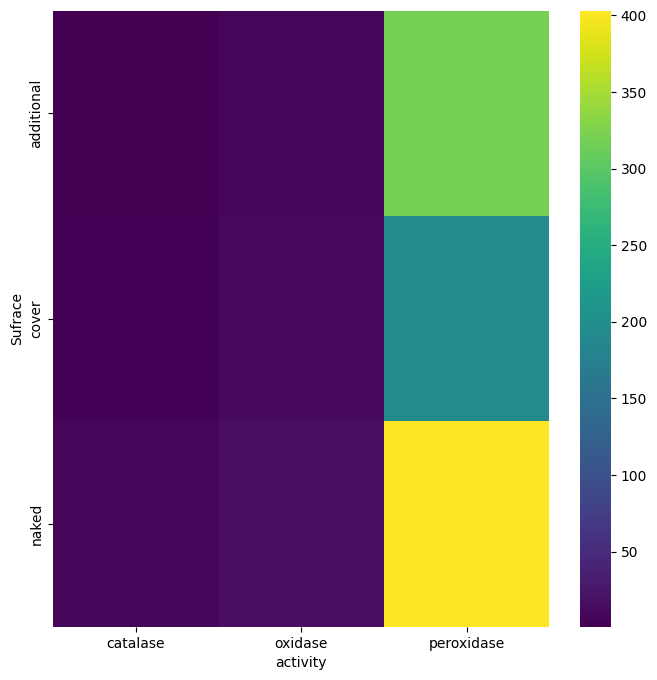

In [128]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Sufrace'].value_counts()
    for x_label, grp in df.groupby('activity')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('activity')
_ = plt.ylabel('Sufrace')

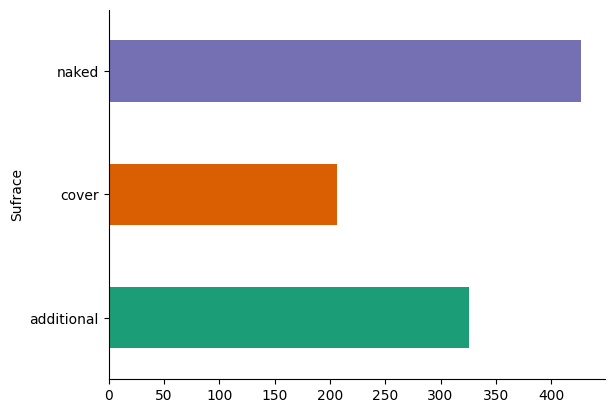

In [129]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('Sufrace').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

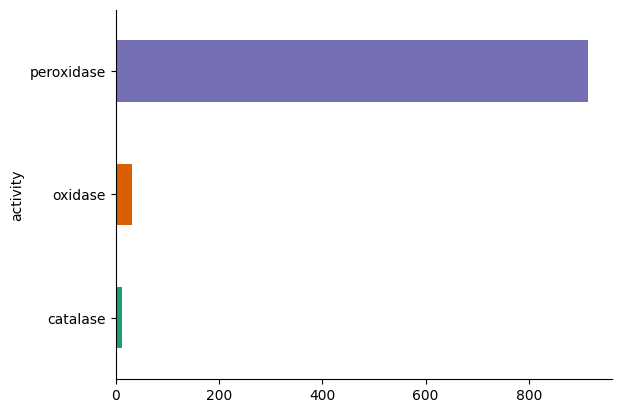

In [130]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('activity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

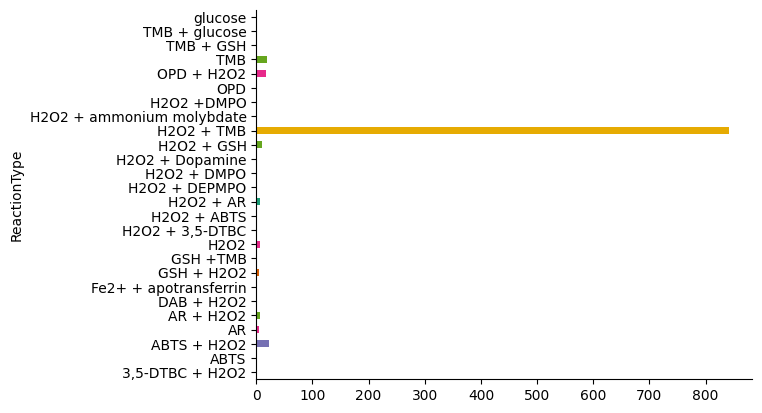

In [131]:
#Рассмотрим наиболее часто встречающиеся реакции

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('ReactionType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

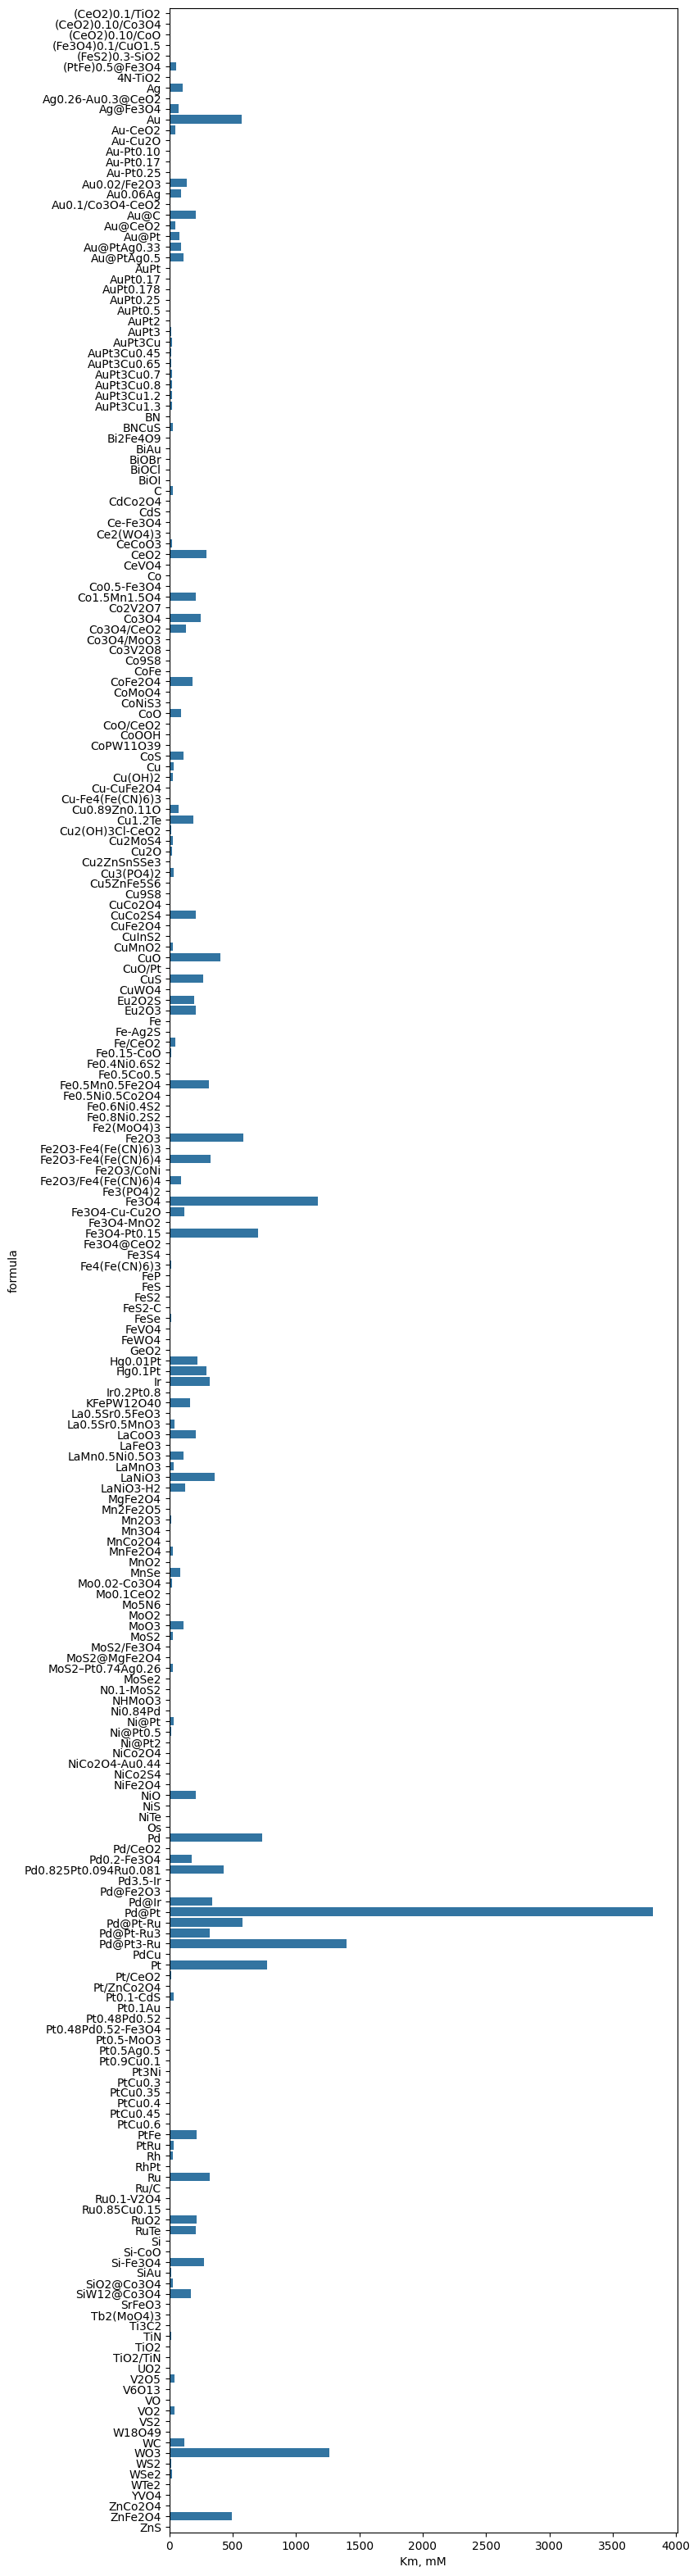

In [132]:
# Самый активный фермент
idx = df.groupby('formula')['Km, mM'].idxmax()
tst = df.loc[idx]

plt.figure()

sns.barplot(data=tst, y="formula", x="Km, mM")

plt.gcf().set_size_inches(8, 40)
plt.show()

<Axes: xlabel='Km, mM', ylabel='ReactionType'>

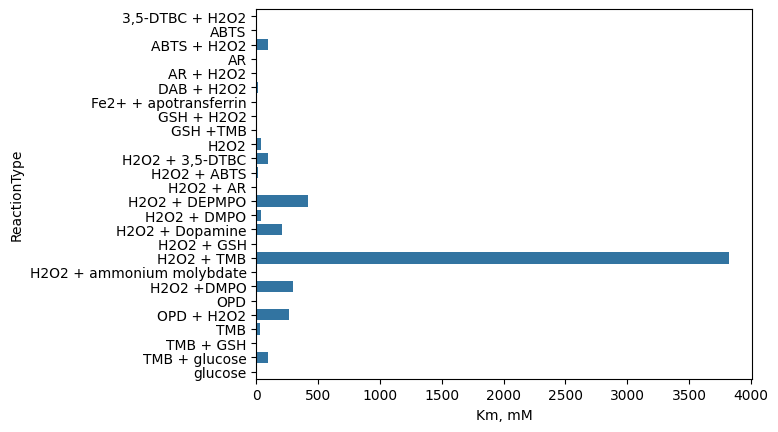

In [133]:
# Сравнение активности согласно типу его реакции

idx = df.groupby('ReactionType')['Km, mM'].idxmax()
tst = df.loc[idx]

sns.barplot(data=tst, y="ReactionType", x="Km, mM")

<Axes: xlabel='Km, mM', ylabel='type'>

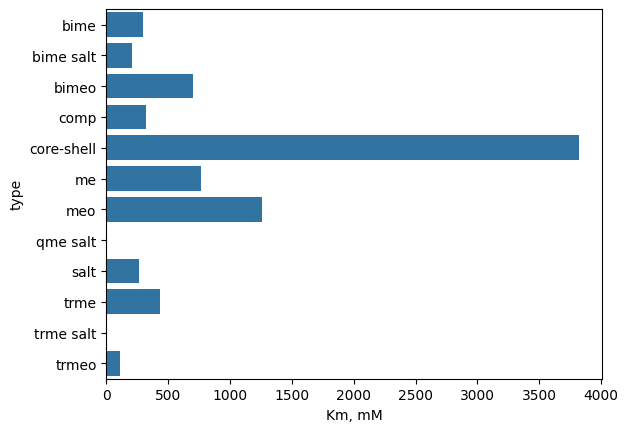

In [134]:
# Сравнение активности согласно типу фермента

idx = df.groupby('type')['Km, mM'].idxmax()
tst = df.loc[idx]

sns.barplot(data=tst, y="type", x="Km, mM")

<Axes: xlabel='Km, mM', ylabel='Sufrace'>

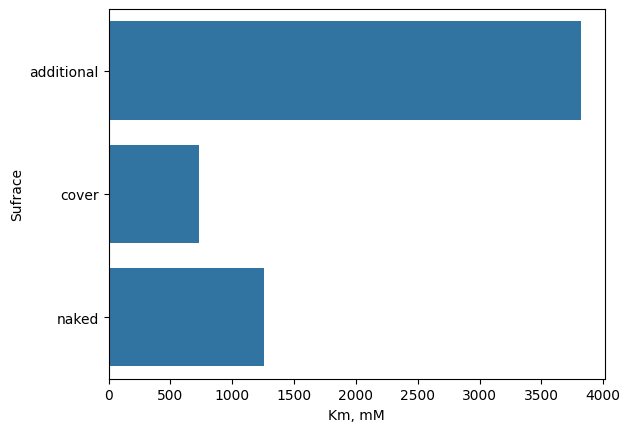

In [135]:
# Сравнение активности согласно его покрытию

idx = df.groupby('Sufrace')['Km, mM'].idxmax()
tst = df.loc[idx]

sns.barplot(data=tst, y="Sufrace", x="Km, mM")

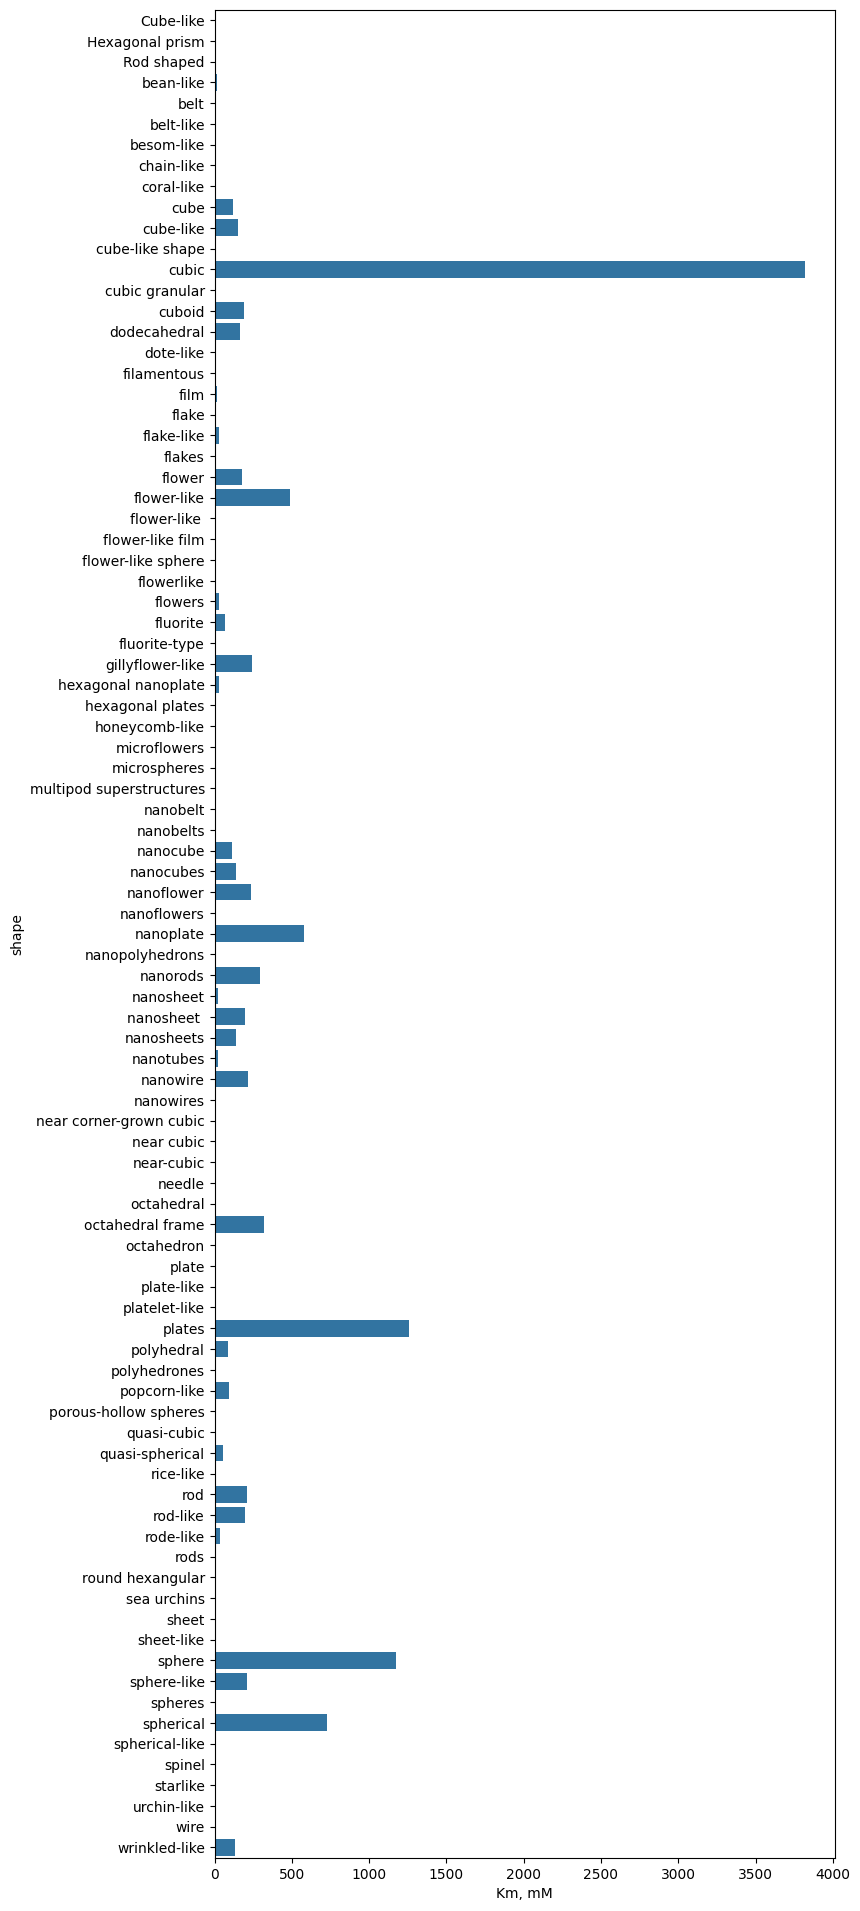

In [136]:
# Сравнение активности согласно его форме

idx = df.groupby('shape')['Km, mM'].idxmax()
tst = df.loc[idx]

sns.barplot(data=tst, y="shape", x="Km, mM")
plt.gcf().set_size_inches(8, 24)
plt.show()

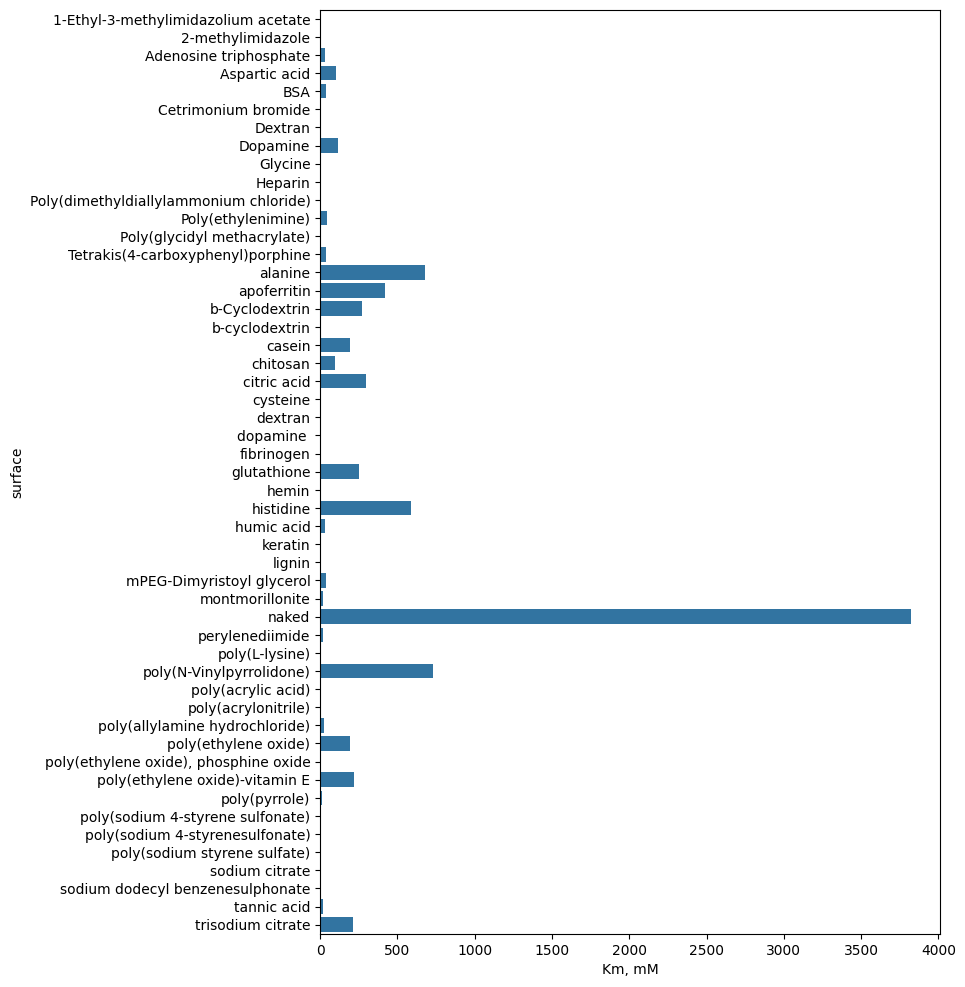

In [137]:
# Сравнение активности согласно его поверхности

idx = df.groupby('surface')['Km, mM'].idxmax()
tst = df.loc[idx]

sns.barplot(data=tst, y="surface", x="Km, mM")
plt.gcf().set_size_inches(8, 12)
plt.show()